In [1]:
from shapes import Point, Rectangle
from environment import Environment2D
from utils import PlotTools
from graph import Graph

import matplotlib.pyplot as plt
import numpy as np
import polytope as pc
%load_ext autoreload
%autoreload 2

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


# Env 1

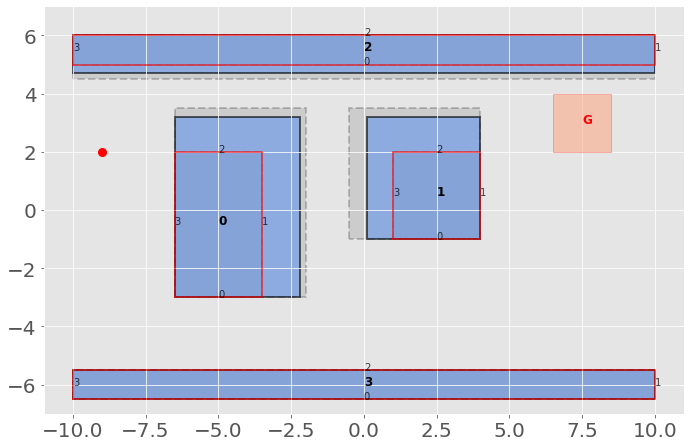

In [8]:
x_lims = [-10,10]
y_lims = [-5,5]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -6.5,-3,3,5,0)
rec_1 = Rectangle(1, 1,-1,3,3,0)
rec_2 = Rectangle(2, -10,5,20,1,0)
rec_3 = Rectangle(3, -10,-6.5,20,1,0)

rec_0.set_error_bounds(np.array([0,0,0,0]), np.array([0,1.5,1.5,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1.5,1.5]))
rec_2.set_error_bounds(np.array([0,0,0,0]), np.array([0.5,0,0,0]))

rec_0.set_actual_errors(np.array([0,1.3,1.2,0]))
rec_1.set_actual_errors(np.array([0,0,1.2,0.9]))
rec_2.set_actual_errors(np.array([0.3,0,0,0]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3])

env.plot()
x_start = Point(-9, 2)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)

# Env 2

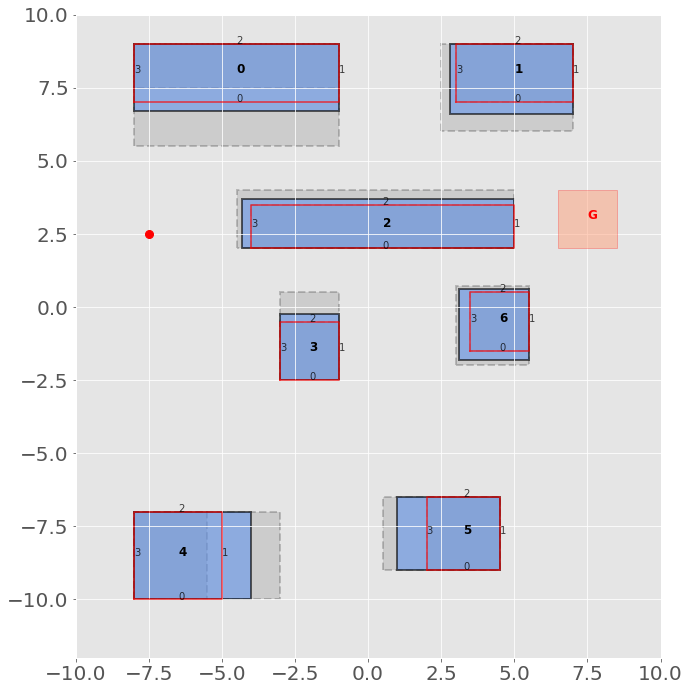

In [37]:
x_lims = [-10,10]
y_lims = [-12,10]
env = Environment2D(x_lims, y_lims)

rec_0 = Rectangle(0, -8,7,7,2,0)
rec_1 = Rectangle(1, 3,7,4,2,0)
rec_2 = Rectangle(2, -4,2,9,1.5,0)
rec_3 = Rectangle(3, -3,-2.5,2,2,0)
rec_4 = Rectangle(4, -8,-10,3,3,0)
rec_5 = Rectangle(5, 2,-9,2.5,2.5,0)
rec_6 = Rectangle(6, 3.5,-1.5,2,2,0)

rec_0.set_error_bounds(np.array([-0.5,0,0,0]), np.array([1.5,0,0,0]))
rec_1.set_error_bounds(np.array([0,0,0,0]), np.array([1,0,0,0.5]))
rec_2.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0.5,0.5]))
rec_3.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,1,0]))
rec_4.set_error_bounds(np.array([0,-0.5,0,0]), np.array([0,2,0,0]))
rec_5.set_error_bounds(np.array([0,0,0,0]), np.array([0,0,0,1.5]))
rec_6.set_error_bounds(np.array([0,0,0,0]), np.array([0.5,0,0.2,0.5]))

rec_0.set_actual_errors(np.array([0.3,0,0,0]))
rec_1.set_actual_errors(np.array([0.4,0,0,0.2]))
rec_2.set_actual_errors(np.array([0,0,0.2,0.3]))
rec_3.set_actual_errors(np.array([0,0,0.25,0]))
rec_4.set_actual_errors(np.array([0,1,0,0]))
rec_5.set_actual_errors(np.array([0,0,0,1]))
rec_6.set_actual_errors(np.array([0.3,0,0.1,0.4]))

env.add_rectangles([rec_0, rec_1, rec_2, rec_3, rec_4, rec_5, rec_6])

env.plot()
x_start = Point(-7.5, 2.5)
x_start.plot()
goal_region = Rectangle(-1, 6.5,2,2,2,0)
goal_region.plot(as_goal=True)